<a href="https://colab.research.google.com/github/DastanIqbal/LearnOpenCV/blob/main/src/OpenCV/dlap/week6/FineTuneImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine Tunning**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.1


In [2]:
!pip install kaggle

**Load Dataset**

In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sriramr/apples-bananas-oranges

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes
Dataset URL: https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges
License(s): unknown
 97% 497M/512M [00:04<00:00, 133MB/s]
100% 512M/512M [00:04<00:00, 108MB/s]


In [4]:
# !rm -rf original_data_set
# !rm -rf fruits
!unzip -q apples-bananas-oranges.zip

In [5]:
main_path = 'original_data_set/original_data_set/'

In [6]:
classnames = os.listdir(main_path)
print(classnames)

['rottenbanana', 'freshapples', 'freshbanana', 'rottenoranges', 'rottenapples', 'freshoranges']


In [7]:
for each_class in classnames:
  print("Class: {}, has {} samples".format(each_class, len(os.listdir(os.path.join(main_path, each_class)))))

Class: rottenbanana, has 306 samples
Class: freshapples, has 232 samples
Class: freshbanana, has 218 samples
Class: rottenoranges, has 222 samples
Class: rottenapples, has 328 samples
Class: freshoranges, has 206 samples


**Arrange your Data** (15% Validation 85% folder)

In [8]:
base_dir = 'fruits'

total_train_images = 0
total_val_images = 0

os.mkdir(base_dir)
train_dir = os.path.join(base_dir,'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir,'validation')
os.mkdir(validation_dir)

validation_percent = 15

for each_class in classnames:

  source_directory = os.path.join(main_path,each_class)
  destination_train_directory = os.path.join(train_dir, each_class)
  destination_validation_directory = os.path.join(validation_dir, each_class)

  total_image_count = len(os.listdir(source_directory))

  valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

  train_image_count = int(total_image_count - valid_image_count)

  total_train_images += train_image_count
  total_val_images += valid_image_count

  os.mkdir(destination_train_directory)
  os.mkdir(destination_validation_directory)

  file_names = os.listdir(source_directory)[:train_image_count]

  for fname in file_names:
    src = os.path.join(source_directory, fname)
    dst = os.path.join(destination_train_directory, fname)
    shutil.copyfile(src, dst)

  file_names = os.listdir(source_directory)[train_image_count:]

  for fname in file_names:
    src = os.path.join(source_directory,fname)
    dst = os.path.join(destination_validation_directory, fname)
    shutil.copyfile(src, dst)

  print("total training {} images: {}".format(each_class, len(os.listdir(destination_train_directory))))
  print("total validation {} images: {}".format(each_class, len(os.listdir(destination_validation_directory))))



total training rottenbanana images: 261
total validation rottenbanana images: 45
total training freshapples images: 198
total validation freshapples images: 34
total training freshbanana images: 186
total validation freshbanana images: 32
total training rottenoranges images: 189
total validation rottenoranges images: 33
total training rottenapples images: 279
total validation rottenapples images: 49
total training freshoranges images: 176
total validation freshoranges images: 30


**Freeze the required layers**

Experiment 1: Freezing all layers - Same as Transfer Learning




In [9]:
from tensorflow.keras.applications import VGG16

image_size = 224

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
# Load the VGG model
vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size, 3))

for layer in vgg_conv.layers[:]:
  layer.trainable = False

for layer in vgg_conv.layers:
  print(layer, layer.trainable)


model = models.Sequential()

model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation = 'softmax'))

model.summary()


<InputLayer name=input_layer_9, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> False
<MaxPooling2D name=block5_pool, built=True> False


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Setup the data generators

In [ ]:
train_datagen = ImageDataGenerator(rescale =1./255)
validation_datagen = ImageDataGenerator(rescale =1./255)

train_batchsize = 20
val_batchsize = 20

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (image_size, image_size),
                                                    batch_size = train_batchsize,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size = (image_size, image_size),
                                                    batch_size = val_batchsize,
                                                    class_mode = 'categorical',
                                                    shuffle = False)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


Train the model

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.RMSprop(learning_rate=0.0001),
    metrics = ['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = int(train_generator.samples/train_generator.batch_size),
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = int(validation_generator.samples/validation_generator.batch_size),
    verbose = 1)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - acc: 0.5230 - loss: 1.3970 - val_acc: 0.8227 - val_loss: 0.4885
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9000 - loss: 0.4371 - val_acc: 0.0000e+00 - val_loss: 1.0466
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - acc: 0.8350 - loss: 0.4764 - val_acc: 0.8364 - val_loss: 0.3855
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.7500 - loss: 0.4955 - val_acc: 0.3333 - val_loss: 0.9240
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - acc: 0.9022 - loss: 0.3046 - val_acc: 0.8136 - val_loss: 0.4365
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.9000 - loss: 0.4570 - val_acc: 0.3333 - val_loss: 0.9343
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - acc: 0.9190 - loss: 0.2427 - val_acc: 0.9182 - val_loss: 0.2175
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9500 - loss: 0.1889 - val_acc: 0.0000e+00 - val_loss: 1.9194
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/s

Save the model

In [ ]:
model.save("all_freezed.h5")

In [ ]:
from google.colab import files
# files.download("all_freezed.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check Performance

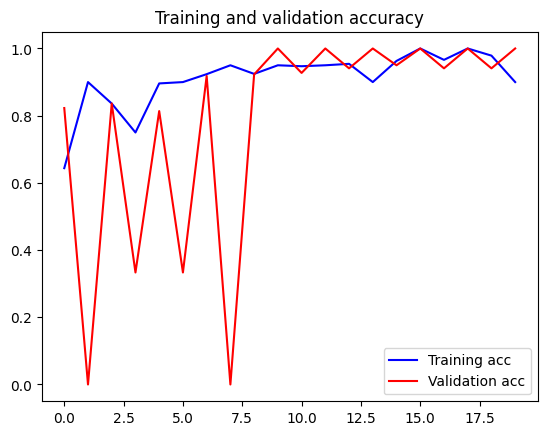

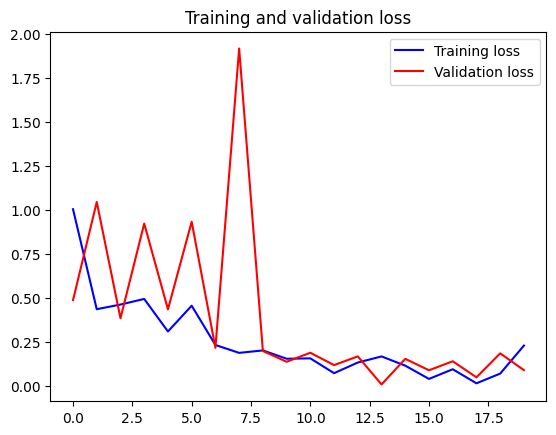

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Show the errors

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

idx2label = dict((v,k) for k,v in label2index.items())

predictions = model.predict(validation_generator, verbose = 1)
predicted_classes = np.argmax(predictions, axis = 1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

for i in range(len(errors)):
  pred_class = np.argmax(predictions[errors[i]])
  pred_label = idx2label[pred_class]

  title = "Original label:{}, Prediction :{}, confidence: {:.3f}".format(
      fnames[errors[i]].split('/')[0],
      pred_label,
      predictions[errors[i]][pred_class]
  )

  original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))

  plt.figure(figsize = [7,7])
  plt.axis("off")
  plt.title(title)
  plt.imshow(original)
  plt.show()

**Expirement 2: Train Last 4 layers without data augmentation**

In [ ]:
vgg_conv = VGG16(weights ="imagenet", include_top=False, input_shape=(image_size,image_size,3))

for layer in vgg_conv.layers[:-4]:
  layer.trainable = False

for layer in vgg_conv.layers:
  print(layer, layer.trainable)


model = models.Sequential()

model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation="softmax"))

model.summary()

<InputLayer name=input_layer_17, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 13,503,750 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Train the model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 50
val_batchsize = 20

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (image_size, image_size),
    batch_size = train_batchsize,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

model.compile(loss="categorical_crossentropy",optimizer = optimizers.RMSprop(learning_rate=1e-4), metrics=["acc"])

history = model.fit(
    train_generator,
    steps_per_epoch = int(train_generator.samples/train_generator.batch_size),
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = int(validation_generator.samples/validation_generator.batch_size),
    verbose = 1)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - acc: 0.4686 - loss: 1.4580 - val_acc: 0.7818 - val_loss: 0.5531
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - acc: 0.7600 - loss: 0.5931 - val_acc: 0.6667 - val_loss: 0.4637
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step - acc: 0.8761 - loss: 0.3440 - val_acc: 0.8955 - val_loss: 0.2619
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8800 - loss: 0.3409 - val_acc: 0.6667 - val_loss: 0.5023
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - acc: 0.9267 - loss: 0.1905 - val_acc: 0.8500 - val_loss: 0.3508
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9200 - loss: 0.1922 - val_acc: 1.0000 - val_loss: 0.2790
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - acc: 0.9777 - loss: 0.0942 - val_acc: 0.9136 - val_loss: 0.2547
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 1.0000 - loss: 0.0207 - val_acc: 1

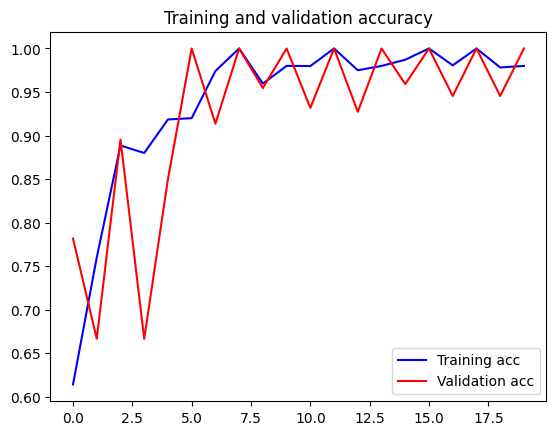

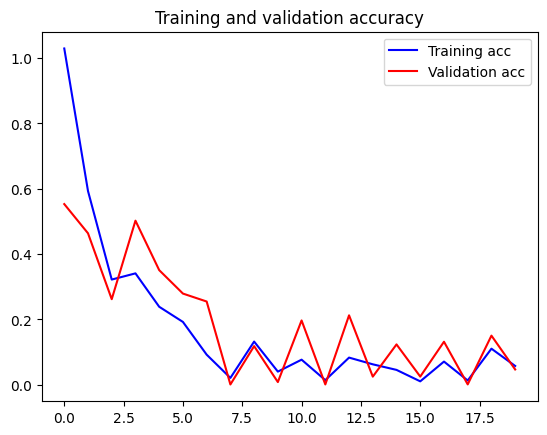

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Show the errors

Found 223 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
No of errors = 189/223


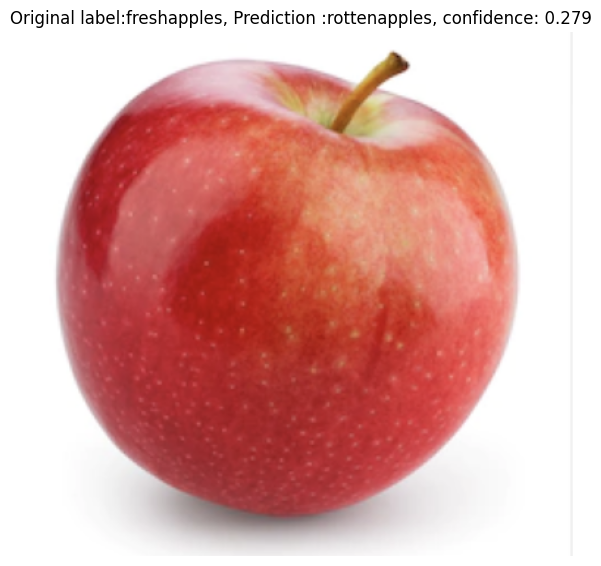

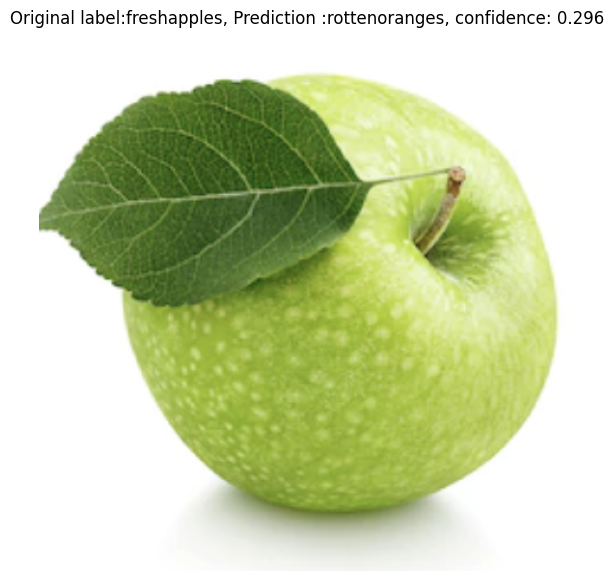

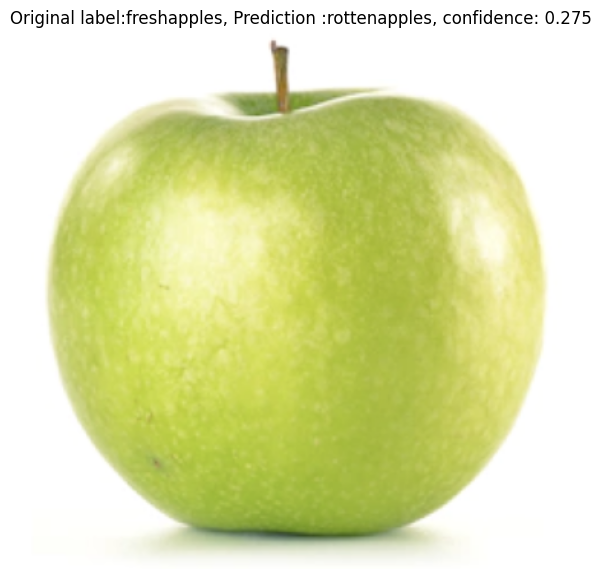

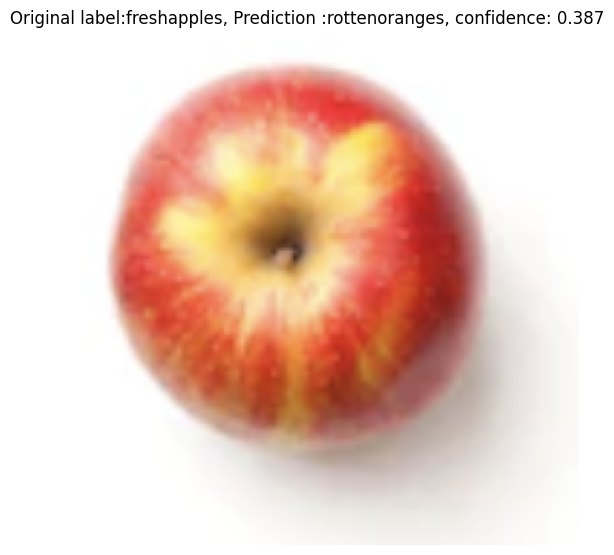

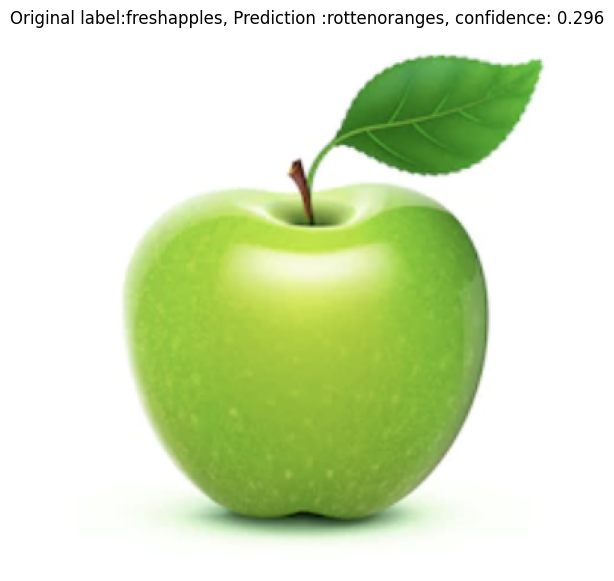

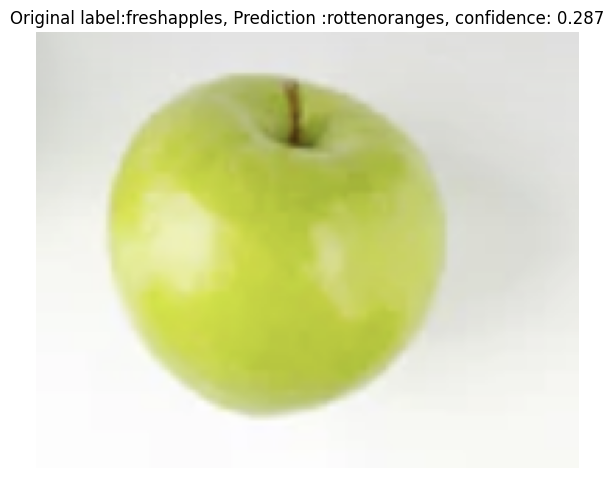

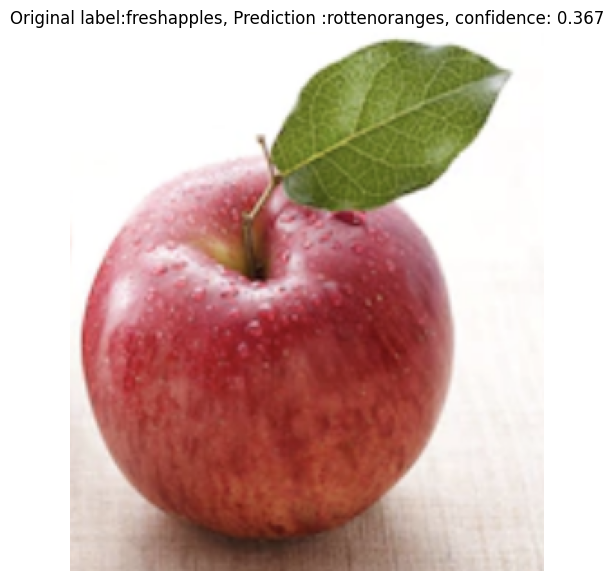

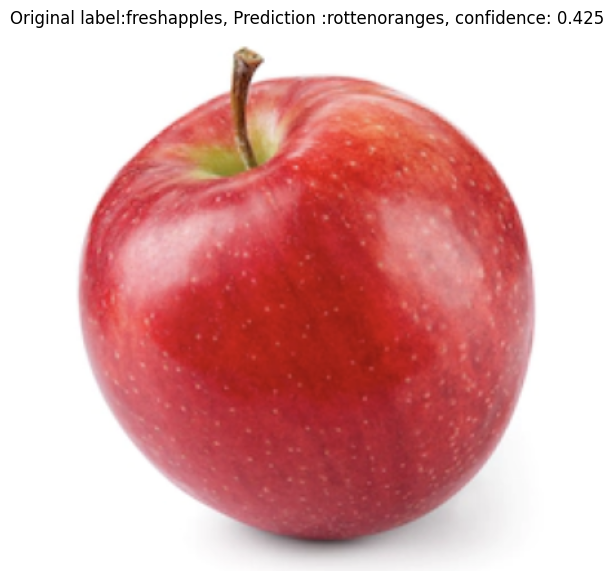

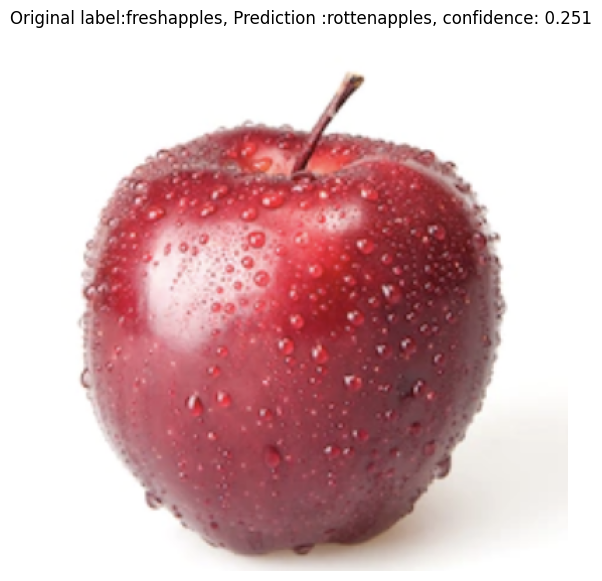

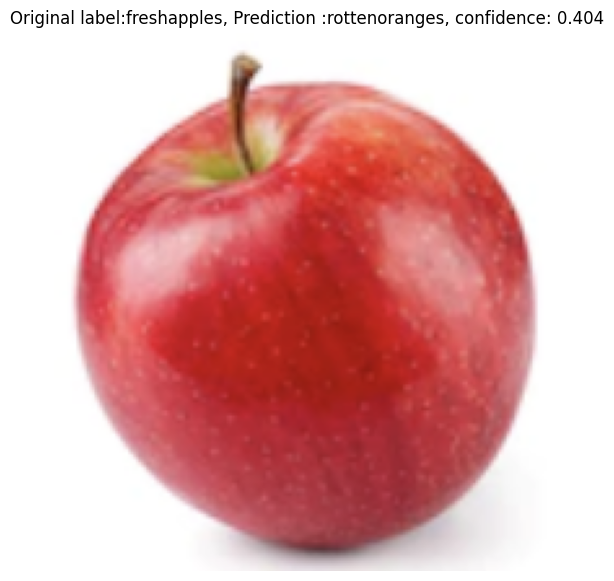

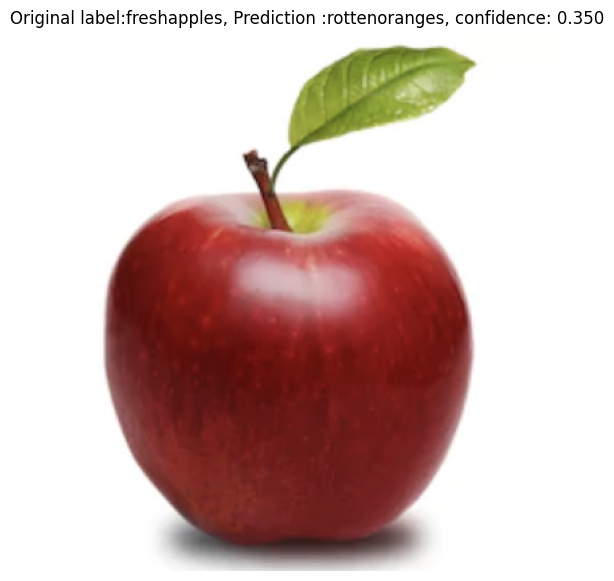

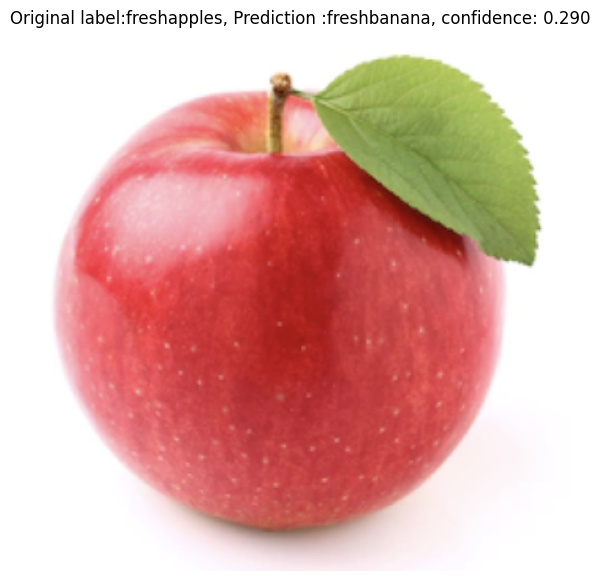

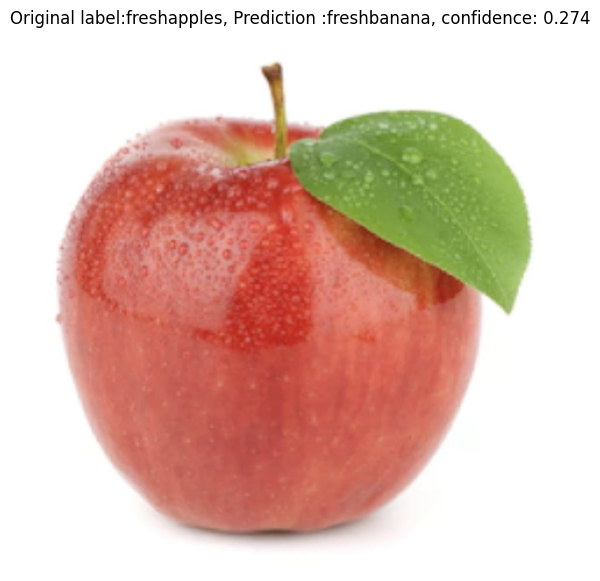

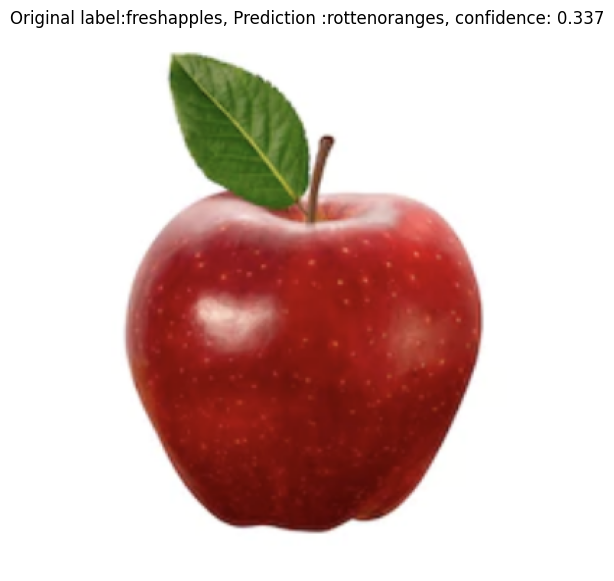

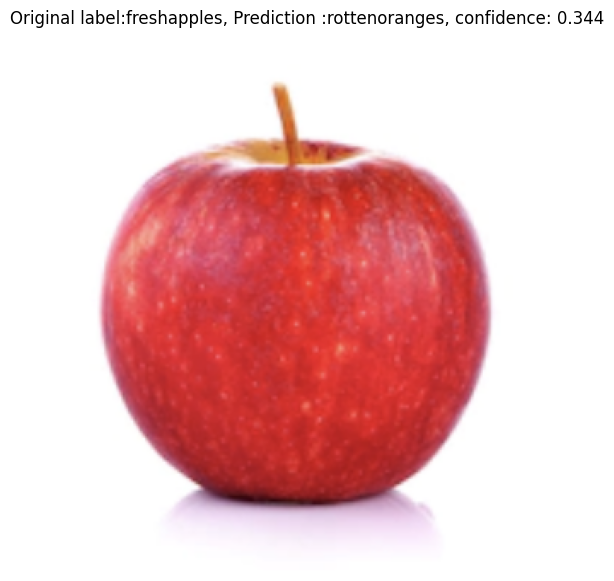

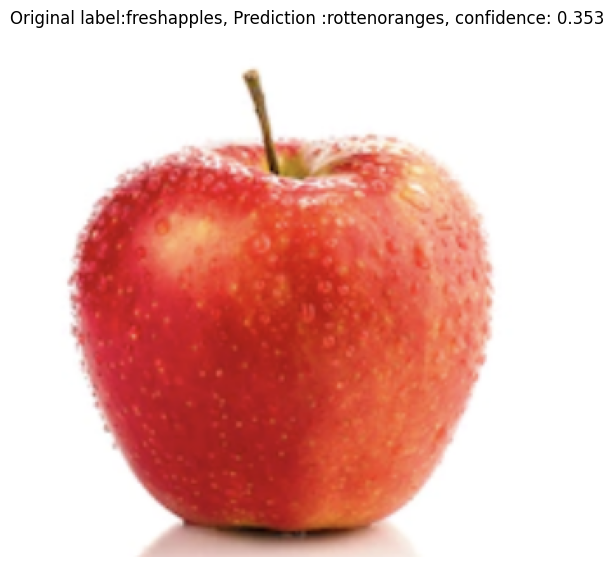

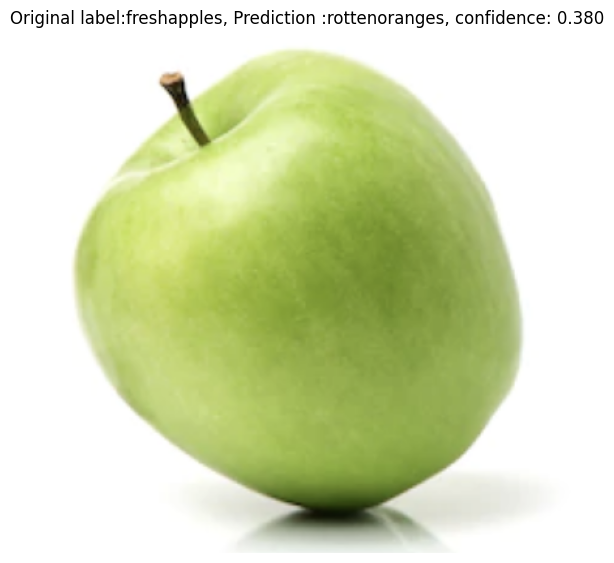

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

idx2label = dict((v,k) for k,v in label2index.items())

predictions = model.predict(validation_generator, verbose = 1)
predicted_classes = np.argmax(predictions, axis = 1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

for i in range(len(errors)):
  pred_class = np.argmax(predictions[errors[i]])
  pred_label = idx2label[pred_class]

  title = "Original label:{}, Prediction :{}, confidence: {:.3f}".format(
      fnames[errors[i]].split('/')[0],
      pred_label,
      predictions[errors[i]][pred_class])

  original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
  plt.figure(figsize = [7,7])
  plt.axis('off')
  plt.title(title)
  plt.imshow(original)
  plt.show()

**Experiment 3: Train last 8 layers with data augmetnation**

In [10]:
vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size,3))

for layer in vgg_conv.layers[:-8]:
  layer.trainable = False

for layer in vgg_conv.layers:
  print(layer, layer.trainable)


model = models.Sequential()

model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation = 'softmax'))

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> True
<Conv2D name=block4_conv2, built=True> True
<Conv2D name=block4_conv3, built=True> True
<MaxPooling2D name=block4_pool, built=True> True
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 19,403,526 (74.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

validataion_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 50
val_batchsize = 20

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (image_size, image_size),
    batch_size = train_batchsize,
    class_mode = 'categorical')

validation_generator = validataion_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizers.RMSprop(learning_rate=1e-4),
    metrics = ['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = int(train_generator.samples/train_generator.batch_size),
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = int(validation_generator.samples/validation_generator.batch_size),
    verbose = 1)


Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - acc: 0.2042 - loss: 1.9047 - val_acc: 0.4909 - val_loss: 1.2819
Epoch 2/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - acc: 0.3600 - loss: 1.5613

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - acc: 0.3600 - loss: 1.5613 - val_acc: 0.0000e+00 - val_loss: 3.4088
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 945ms/step - acc: 0.4938 - loss: 1.3273 - val_acc: 0.7455 - val_loss: 0.6276
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7800 - loss: 0.7965 - val_acc: 0.6667 - val_loss: 0.5829
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 914ms/step - acc: 0.6928 - loss: 0.8149 - val_acc: 0.8227 - val_loss: 0.4484
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7400 - loss: 0.6369 - val_acc: 1.0000 - val_loss: 0.0120
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 874ms/step - acc: 0.7585 - loss: 0.6729 - val_acc: 0.8909 - val_loss: 0.3228
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.8400 - loss: 0.5341 - val_acc: 1.0000 - val_loss: 0.1100
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 909ms/step - acc: 0.8456 - loss: 0.4791 - val_acc: 0.9455 - val_loss: 0.1456
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8800

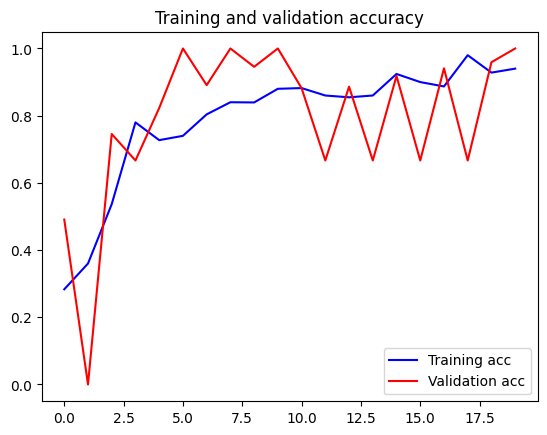

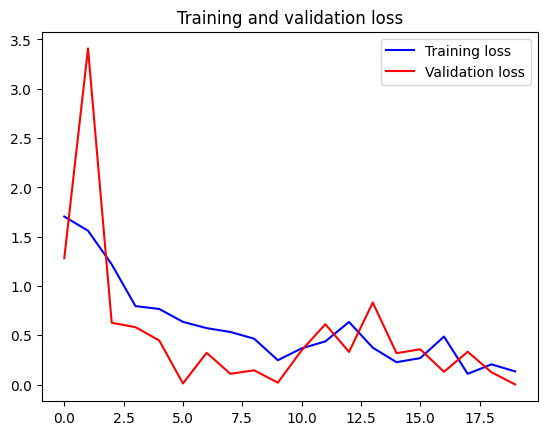

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Show the errros

Found 223 images belonging to 6 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
No of errors = 9/223


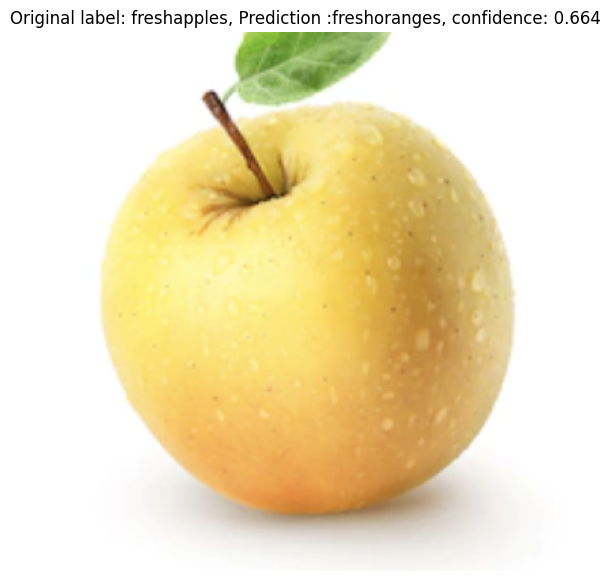

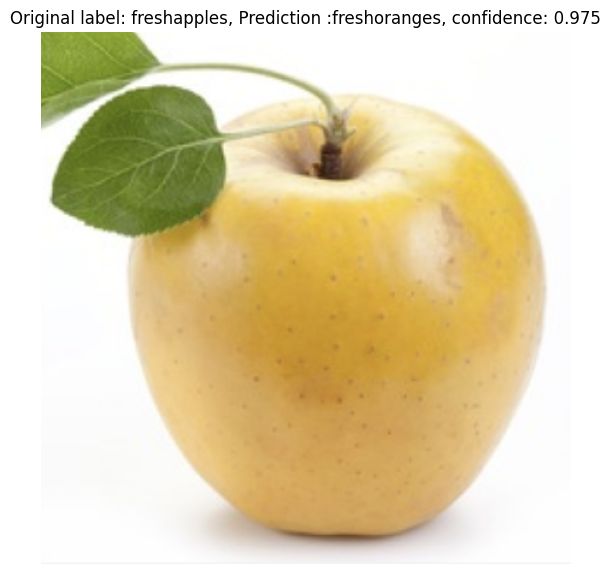

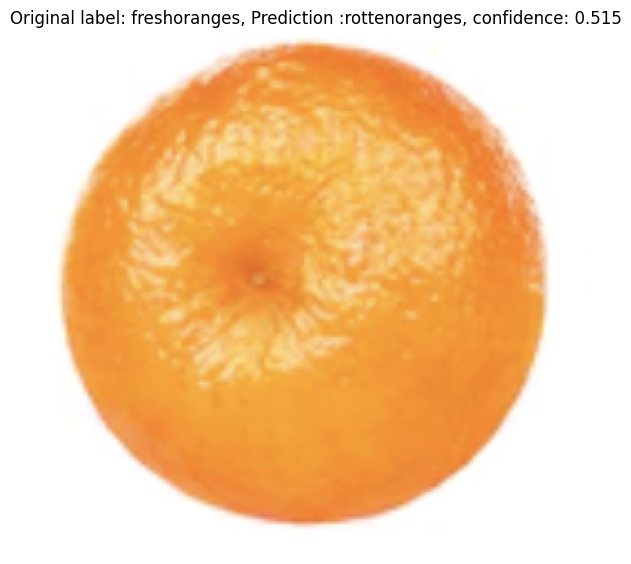

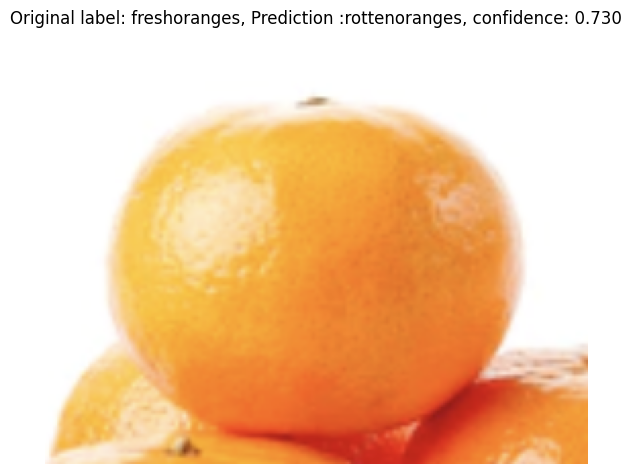

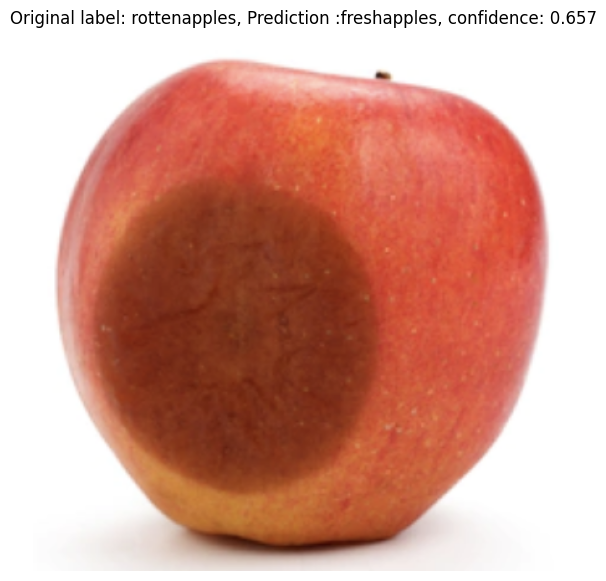

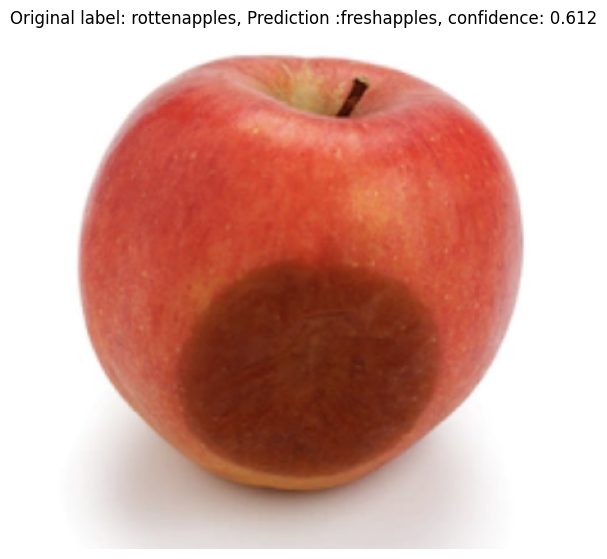

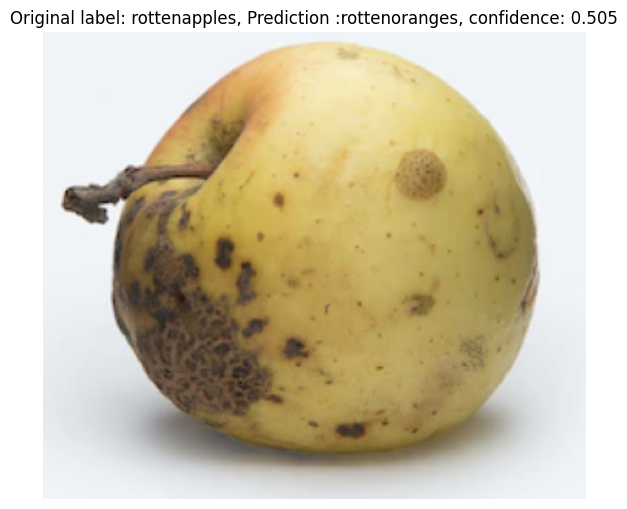

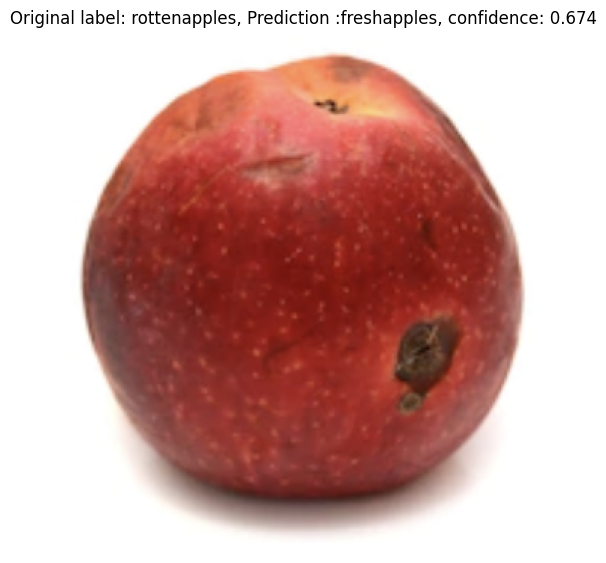

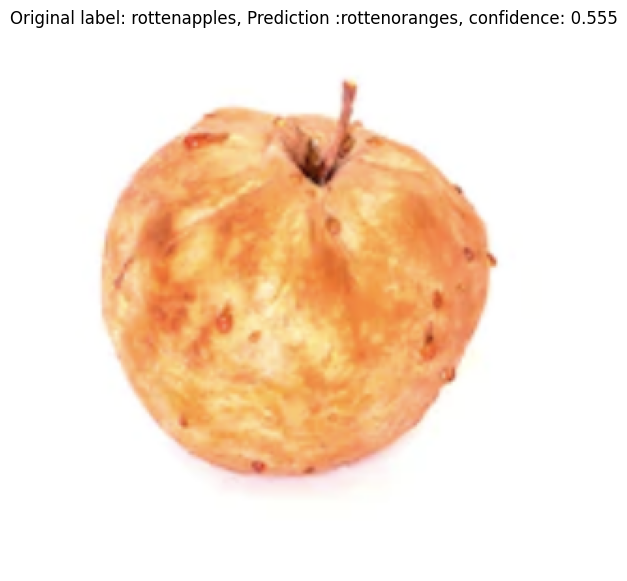

In [14]:
validataion_generator = validataion_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

fnames = validataion_generator.filenames

ground_truth = validataion_generator.classes

label2index = validataion_generator.class_indices

label2index = validataion_generator.class_indices

idx2label = dict((v,k) for k,v in label2index.items())

predictions = model.predict(validataion_generator, verbose = 1)
predicted_classes = np.argmax(predictions, axis = 1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), validataion_generator.samples))

for i in range(len(errors)):
  pred_class = np.argmax(predictions[errors[i]])
  pred_label = idx2label[pred_class]

  title = "Original label: {}, Prediction :{}, confidence: {:.3f}".format(
      fnames[errors[i]].split('/')[0],
      pred_label,
      predictions[errors[i]][pred_class])

  original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))
  plt.figure(figsize = [7,7])
  plt.axis('off')
  plt.title(title)
  plt.imshow(original)
  plt.show()